# Fake News Detector - Model building and training

## Imports

In [1]:
#load relevant libraries/modules
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
import os
import pandas as pd 
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import gensim
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

## Load dataset

In [2]:
#Load data and check out first few lines
data2 = pd.read_csv('../data/interim/data_cleaned.csv')
data2.head()

,Unnamed: 0,Label,Header_and_body,Header_and_body_NoSWs
0,0,1,four ways bob corker skewered donald trump ima...,four ways bob corker skewered donald trump ima...
1,1,1,linklater s war veteran comedy speaks to moder...,linklater s war veteran comedy speaks modern a...
2,2,1,trump s fight with corker jeopardizes his legi...,trump s fight corker jeopardizes legislative a...
3,3,1,egypt s cheiron wins tie up with pemex for mex...,egypt s cheiron wins tie pemex mexican onshore...
4,4,1,jason aldean opens snl with vegas tribute co...,jason aldean opens snl vegas tribute country s...


In [3]:
#We don't need the "Unnamed: 0" and original "Header_and_body" columns
data2 = data2.drop(["Unnamed: 0", "Header_and_body"], axis=1)
data2.head()

,Label,Header_and_body_NoSWs
0,1,four ways bob corker skewered donald trump ima...
1,1,linklater s war veteran comedy speaks modern a...
2,1,trump s fight corker jeopardizes legislative a...
3,1,egypt s cheiron wins tie pemex mexican onshore...
4,1,jason aldean opens snl vegas tribute country s...


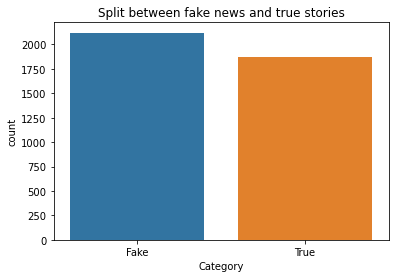

In [4]:
#0 signifies fake news and 1 signifies real/true article.
#Plot split between fake and true labels
sns.countplot(x="Label",
              data=data2)
plt.title("Split between fake news and true stories")
plt.xlabel("Category")
plt.xticks([0, 1], ["Fake", "True"])
plt.show()

It is worth noting that the dataset is relatively well-balanced, so this will have positive implications for how we evaluate the models later on, in that we won't have to factor in that there is a massive imbalance that renders accuracy measures invalid or misleading.



## Create training and test data

As with all model-building for machine learning algorithms, we need to create our training and test datasets, using cleaned and standardised text version of articles, as the X data an the Fake/True labelling of the articles as the target/Y data. However, as this is natural language processing task, we will also need to vectorize the data - see next section.

In [5]:
#Separate source data into text and labels
X = data2['Header_and_body_NoSWs']
y = data2['Label']

In [6]:
#Create training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)


## Vectorization
The next step is to vectorize the data, ie converting the text in each article into numerical entries in the form of vectors/matrices. The are a number of vectorization techniques, including:

-  count vectorization
-  N-Grams
-  Bag of Words (BOW)
-  Term Frequency-Inverse Document Frequency (TF-IDF)
-  Word2Vec

Each have their pros and cons.

Count vectorization generates a document term matrix where each cell is the count corresponding to the news article indicating the number of times a word appears in the document, also known as the term frequency. The document term matrix is a set of dummy variables that indicates if a particular word appears in the document. A column is dedicated to each word in the corpus. The count is directly proportionate to the correlation of the category of the news title. This means, if a particular word appears many times in fake news titles or true news titles, then the particular word has a high predictive power of determining if the news title is fake or true. The vectorizer produces a sparse matrix output, but only the non-zero values are stored in order to save memory.

TF-IDF is similar to count vectorization - a document term matrix is generated and each column represents a single unique word. The difference in the TF-IDF method is that each cell doesn’t indicate the term frequency, but the cell value represents a weighting that highlights the importance of that particular word to the document. The sparse matrix output for this method displays decimals representing the weight of the word in the document. High weight means that the word occurs many times within a few documents and low weight means that the word occurs fewer times in a lot of documents or repeats across multiple documents.

Bag of Words is the simplest technique, involving tokenization, vocabulary creation, and vector creation. BoW is only concerned with the frequency of the words in a particular text, meaning there is limited distinction between different types of words, so that articles, prepositions, conjunctions, etc, may be elevated in importance compared to, say, adjectives, even though the former might not be that relevant.

TF-IDF avoids that issue (in that often-used words don't overpower less frequently used, but important words), and offers more nuance than count vectorization, hence why I decided to use it, in the first instance.

Word2Vec offers an alternative approach (and was apparently developed as a response by a team of Google researchers to the BoW issues). It creates high-dimensional vectors where words are assumed to be completely independent of each other. By using a neural network with only a couple of layers, Word2Vec tries to learn relationships between the words and then embed them in a lower dimensional space. In this way, the representation of the words is said to be contextually aware because the words that have similar meanings are mapped closely together via their vectorization "rating".

So I decided to build models with Word2Vec also, but only after I'd finished building and testing models with TF-IDF - see further below.

In [7]:
#Vectorize the text data
tfidf_vectorizer = TfidfVectorizer(max_df=0.8)
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 
tfidf_test = tfidf_vectorizer.transform(X_test)

## Models

This is a binary classification problem, so I wanted to try a few different classifiers, namely:

-  Passive Aggressive Classifier
-  Random Forest Decision Tree Classifier
-  Logistic Regression Classifier
-  Linear Subject Vector Classifier
-  Naive Bayes Multinomial Classifier

#### Passive Aggressive Classifier
Passive-Aggressive algorithms are similar to a Perceptron model, in the sense that they do not require a learning rate. However, they do include a regularization parameter. The Passive-Aggressive algorithm is so-called because it is both:

-  Passive: If the prediction is correct, the model is kept and no changes are made; and 
-  Aggressive: If the prediction is incorrect, changes are made to the model tocorrect it.

#### Random Forest Classifier
Random Forest – uses a numerous decision trees on subsets of the data and then averages the result to improve the predictive accuracy of the model and reduce the chances of over-fitting (samples are drawn with replacement). This makes the algorithm more accurate than decisions trees also, but means in can be slow in practice and harder to implement.

#### Logistic Regression Classifier
Logistic Regression – the algorithm using a sigmoid function to the model the probabilities describing the possible outcomes of a binary choice. In this way, logistic regression is helping for understanding the impact of a number of different, independent variables on a single outcome variable, which could work well for this fake news dataset. The downside to logistic regression is that very assumption that all the predictors are independent of each other, which may not in fact be the case.

#### Support Vector Machine Classifier
Support Vector Machine – works by representing the training data as points in space, which are then divided into categories with as clear and wide a gap as possible between the different categories. The test examples are then mapped into the same area and predicted to belong to each category based on which side of the gap they end up on. Support Vector Machine models have the benefits of being effective in high dimensional spaces, so this could work well in natural language processing, and it is also a memory efficient algorithm. One disadvantage is that it doesn’t directly provide probability estimates, which need to be done by five-fold cross-validation.

#### Multinomial Naive Bayes Classifier
Naïve Bayes – works well in real-world situations such as document classification and spam filtering, and is based on Bayes’ theorem and the assumption of independence between every pair of features. A couple of pluses are that it only need a small amount of training data to estimate the required parameters and it’s a very fast method. One the downside, it has a reputation as a bad estimator.

#### Evaluation
For each model, I will look at the general accuracy as the initial evaluation measure, but also prodcue a confusions matrix and print out a classification report. 

The most common metric for classification is accuracy, which is the fraction of samples predicted correctly. This is a relatively balanced dataset so, there is less concern over the validity of the accuracy score (which can be deceptive in eg, something like rare cancer screening, where there many only be a small fraction of actual positives), but it's still helpful to see.

The classificaton report helps us with:

-  Recall (also known as sensitivity), ie, the fraction of positives events that have been predicted correctly
-  Precision, ie, the fraction of predicted positives events that are actually positive. Precision is probably the most important metric in this task - as we want to reduce the number of false negatives.
-  The f1 score, ie the harmonic mean of recall and precision, with a higher score being a better model. So important here in relation to fakes news/(ie, O label).

### Passive Aggressive Classifier

In [8]:
#Instantiate the model
PACmodel = PassiveAggressiveClassifier(max_iter=50, random_state = 5)
PACmodel.fit(tfidf_train, y_train)

PassiveAggressiveClassifier(max_iter=50, random_state=5)

In [9]:
#Make predictions and score
y_pred = PACmodel.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)
 
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  98.37 %


[[403   6]
 [  7 382]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\3990613843.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\3990613843.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


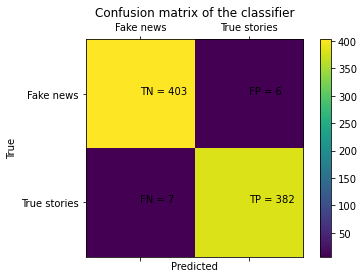

In [10]:
#Create a confusion matrix
labels = ['Fake news', 'True stories']
cm = confusion_matrix(y_test, y_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [11]:
#Print a classification report
print("                       Classification_report")
print()
print(classification_report(y_pred , y_test))

                       Classification_report

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       410
           1       0.98      0.98      0.98       388

    accuracy                           0.98       798
   macro avg       0.98      0.98      0.98       798
weighted avg       0.98      0.98      0.98       798



### Random Forest Classifier

In [12]:
#Instantiate
RFCmodel = RandomForestClassifier(random_state=0)

#Fitting training set to the model
RFCmodel.fit(tfidf_train, y_train)

#Predicting the test set results based on the model
y_pred = RFCmodel.predict(tfidf_test)

#Calculate the accuracy score of this model
score = accuracy_score(y_test, y_pred)
 
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  96.49 %


In [13]:
#Create a function for confusion matrices from now on
def plot_confusion_matrix(y_test, y_pred, label1, label2, model):
    '''Function to plot confusion matrix'''
    labels = [label1, label2]
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the ' + model + ' classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

[[386  23]
 [  5 384]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


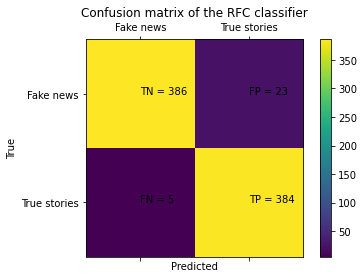

In [14]:
#Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'RFC')

In [15]:
print("                       Classification_report")
print()
print(classification_report(y_pred , y_test))

                       Classification_report

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       391
           1       0.99      0.94      0.96       407

    accuracy                           0.96       798
   macro avg       0.97      0.97      0.96       798
weighted avg       0.97      0.96      0.96       798



In [16]:
#Try Logistic regression model
LogRmodel = LogisticRegression()

#Fitting training set to the model
LogRmodel.fit(tfidf_train, y_train)

#Predicting the test set results based on the model
y_pred = LogRmodel.predict(tfidf_test)

#Calculate the accuracy score of this model
score = accuracy_score(y_test, y_pred)
 
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  97.37 %


[[397  12]
 [  9 380]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


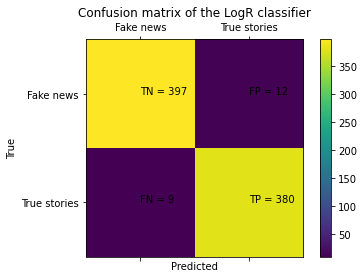

In [17]:
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'LogR')

In [18]:
print("                       Classification_report")
print()
print(classification_report(y_pred , y_test))

                       Classification_report

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       406
           1       0.98      0.97      0.97       392

    accuracy                           0.97       798
   macro avg       0.97      0.97      0.97       798
weighted avg       0.97      0.97      0.97       798



### Linear Subject Vector Machine

The linear version of the subject vector machine algorithms is used here, because our fake news data is linearly separable, ie, with a single line. Generally, the linear version is used when there are large number of features which will be the case here, with text classification.


In [19]:
#Linear Subject Vector model
LinSVMmodel = LinearSVC(random_state=0)

#Fitting training set to the model
LinSVMmodel.fit(tfidf_train, y_train)

#Predicting the test set results based on the model
y_pred = LinSVMmodel.predict(tfidf_test)

#Calculate the accuracy score of this model
score = accuracy_score(y_test, y_pred)
 
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  98.5 %


[[401   8]
 [  4 385]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


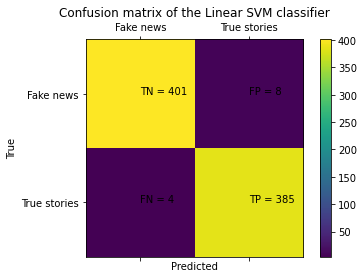

In [20]:
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'Linear SVM')

In [21]:
print("                       Classification_report")
print()
print(classification_report(y_pred , y_test))

                       Classification_report

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       405
           1       0.99      0.98      0.98       393

    accuracy                           0.98       798
   macro avg       0.99      0.98      0.98       798
weighted avg       0.99      0.98      0.98       798



### Multinomial Naive Bayes Classifier

In [22]:
#Naive Bayes
MultiNomNBmodel = MultinomialNB()

#Fitting training set to the model
MultiNomNBmodel.fit(tfidf_train, y_train)

#Predicting the test set results based on the model
y_pred = MultiNomNBmodel.predict(tfidf_test)

#Calculate the accuracy score of this model
score = accuracy_score(y_test, y_pred)
 
print("Accuracy: ",round(score*100,2),"%")


Accuracy:  93.86 %


[[381  28]
 [ 21 368]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


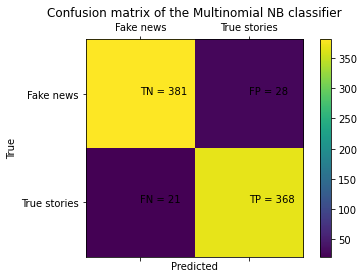

In [23]:
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'Multinomial NB')

In [24]:
print("                       Classification_report")
print()
print(classification_report(y_pred , y_test))

                       Classification_report

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       402
           1       0.95      0.93      0.94       396

    accuracy                           0.94       798
   macro avg       0.94      0.94      0.94       798
weighted avg       0.94      0.94      0.94       798



All models had good accuracy results:

-  Passive Aggressive - 98.37%
-  Random Forest - 96.49%
-  Logistic Regression - 97.37%
-  Linear SVM - 98.5%
-  Multinomial Naive Bayes - 93.86%

However, the two that stood out were the PassiveAggressive Classifier and the Linear SVM Classifier. Not only were their accuracy scores slightly higher, but the number of false positives (ie, the number of fakes news stories that they let through) were significantly lower than the other alorigthms (6 and 8, respectively, compared to double figures for the others and sometimes into the high 20s).

### Word2Vec vectorization
As mentioned above, I was also keen to try an alternative form of word vectorization to see if I could improve the model.

In [25]:
# Clean data using the built in cleaner in gensim
data2['text_clean'] = data2['Header_and_body_NoSWs'].apply(lambda x: gensim.utils.simple_preprocess(x))
data2.head()

,Label,Header_and_body_NoSWs,text_clean
0,1,four ways bob corker skewered donald trump ima...,"[four, ways, bob, corker, skewered, donald, tr..."
1,1,linklater s war veteran comedy speaks modern a...,"[linklater, war, veteran, comedy, speaks, mode..."
2,1,trump s fight corker jeopardizes legislative a...,"[trump, fight, corker, jeopardizes, legislativ..."
3,1,egypt s cheiron wins tie pemex mexican onshore...,"[egypt, cheiron, wins, tie, pemex, mexican, on..."
4,1,jason aldean opens snl vegas tribute country s...,"[jason, aldean, opens, snl, vegas, tribute, co..."


With some datasets you might need to encoding the label column, eg, through mapping, but here the label column is already in binary form.


In [26]:
# Split data into train and test sets
X_trainW2V, X_testW2V, y_trainW2V, y_testW2V = train_test_split (data2['text_clean'], data2['Label'] , test_size=0.2)

In [27]:
# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_trainW2V,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

In [28]:
w2v_model.wv.index_to_key

['said',
 'will',
 'one',
 'new',
 'trump',
 'two',
 'first',
 'year',
 'people',
 'game',
 'time',
 'us',
 'now',
 'last',
 'news',
 'week',
 'mr',
 'president',
 'world',
 'back',
 'state',
 're',
 'may',
 'season',
 'years',
 'many',
 'government',
 'story',
 'even',
 'content',
 'team',
 'going',
 'make',
 'three',
 'don',
 'reuters',
 'still',
 'told',
 'made',
 'play',
 'states',
 'times',
 'york',
 'think',
 'day',
 'home',
 'united',
 'way',
 'source',
 'police',
 'take',
 'see',
 'much',
 'well',
 'national',
 'good',
 'says',
 'long',
 'country',
 'october',
 'go',
 'say',
 'caption',
 'know',
 'right',
 'yards',
 'another',
 'media',
 'north',
 'including',
 'photos',
 'games',
 'around',
 'work',
 'image',
 'players',
 'next',
 'company',
 'continue',
 'part',
 'law',
 'house',
 'must',
 'end',
 'video',
 'night',
 'second',
 'twitter',
 'million',
 'please',
 'ravens',
 'want',
 'according',
 'weinstein',
 'women',
 'used',
 'top',
 'photo',
 'american',
 'run',
 'need',
 

In [29]:
# Find the most similar words to "king" based on word vectors from our trained model
w2v_model.wv.most_similar('king')

[('fallon', 0.9801495671272278),
 ('christine', 0.9742156863212585),
 ('sara', 0.9741397500038147),
 ('jennifer', 0.973686158657074),
 ('ahmed', 0.9736212491989136),
 ('dylan', 0.9734424352645874),
 ('elizabeth', 0.973308801651001),
 ('thornton', 0.9730697870254517),
 ('ing', 0.9728824496269226),
 ('jourdan', 0.9728155136108398)]

In [30]:
#Generate aggregated sentence vectors based on the word vectors for each word in the sentence
words = set(w2v_model.wv.index_to_key )
X_trainW2V_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_trainW2V])
X_testW2V_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_testW2V])

C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\3519776823.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_trainW2V_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\3519776823.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_testW2V_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


In [31]:
#Loop through this array of arrays created in above. 
#Each sentence has a different number of array vectors which may cause an error in model training
# Why is the length of the sentence different than the length of the sentence vector?

for i, v in enumerate(X_trainW2V_vect):
    print(len(X_trainW2V.iloc[i]), len(v))

212 212
357 352
43 43
351 351
19 19
270 269
476 476
356 342
552 552
354 352
32 32
697 693
24 24
370 367
433 427
270 263
412 410
467 467
16 16
464 464
37 36
23 23
538 519
34 33
288 282
497 488
476 472
143 141
810 759
741 733
165 165
38 36
407 400
691 680
431 414
134 134
12 12
14 14
20 20
184 184
359 359
25 25
430 430
467 419
35 35
79 79
427 411
23 23
21 21
18 18
20 20
287 287
589 571
349 338
20 20
169 168
1652 1630
226 224
108 108
109 109
82 82
168 164
32 32
95 92
293 293
12 12
118 107
261 261
38 38
20 20
1707 1707
373 373
21 21
204 201
465 457
107 104
44 43
433 421
584 579
414 405
150 148
430 417
394 391
330 326
917 896
256 254
167 167
24 24
156 153
107 107
76 76
168 166
215 203
27 27
28 28
640 640
534 529
126 126
28 28
13 13
517 479
647 644
286 286
211 211
37 36
194 192
241 234
66 66
234 230
403 400
27 27
136 135
128 128
921 921
55 54
312 312
186 185
13 13
448 437
536 530
51 51
30 30
443 438
877 876
115 115
201 201
27 27
35 35
177 177
65 65
125 124
475 470
257 257
256 250
116 111
257 

319 309
38 37
141 140
221 216
363 356
140 140
329 313
153 153
313 307
233 233
533 526
22 22
170 170
288 288
151 147
1707 1707
166 165
316 316
24 24
33 33
244 244
642 636
519 503
22 22
445 438
22 22
587 587
117 115
141 141
341 341
419 416
262 262
458 436
149 147
304 291
346 344
167 164
290 290
645 645
258 258
599 599
765 744
787 787
253 249
356 350
210 204
21 21
307 292
442 439
170 170
85 84
28 28
130 130
287 282
195 195
37 37
500 500
203 198
192 191
149 148
584 571
200 200
478 463
17 17
2253 2192
186 185
31 31
20 20
348 346
299 287
671 671
476 471
151 151
167 167
541 535
44 44
560 560
327 317
373 373
302 302
1149 1084
209 203
612 612
167 165
412 412
394 385
184 184
175 168
30 30
23 23
186 186
182 182
259 245
415 404
38 38
195 192
89 89
350 341
88 88
260 259
35 35
90 90
21 21
48 48
102 101
255 255
437 437
1298 1199
195 188
244 244
68 68
262 245
610 610
193 193
380 376
707 703
24 24
225 224
25 25
1014 1009
731 731
25 25
248 248
98 95
494 494
259 248
1015 1000
448 442
163 161
113 113
630 

In [32]:
# Make sentence vectors consistent by averaging the word vectors for the words contained in the sentence
X_trainW2V_vect_avg = []
for v in X_trainW2V_vect:
    if v.size:
        X_trainW2V_vect_avg.append(v.mean(axis=0))
    else:
        X_trainW2V_vect_avg.append(np.zeros(100, dtype=float))
        
X_testW2V_vect_avg = []
for v in X_testW2V_vect:
    if v.size:
        X_testW2V_vect_avg.append(v.mean(axis=0))
    else:
        X_testW2V_vect_avg.append(np.zeros(100, dtype=float))

In [33]:
# Check sentence vector lengths consistent?
for i, v in enumerate(X_trainW2V_vect_avg):
    print(len(X_trainW2V.iloc[i]), len(v))

212 100
357 100
43 100
351 100
19 100
270 100
476 100
356 100
552 100
354 100
32 100
697 100
24 100
370 100
433 100
270 100
412 100
467 100
16 100
464 100
37 100
23 100
538 100
34 100
288 100
497 100
476 100
143 100
810 100
741 100
165 100
38 100
407 100
691 100
431 100
134 100
12 100
14 100
20 100
184 100
359 100
25 100
430 100
467 100
35 100
79 100
427 100
23 100
21 100
18 100
20 100
287 100
589 100
349 100
20 100
169 100
1652 100
226 100
108 100
109 100
82 100
168 100
32 100
95 100
293 100
12 100
118 100
261 100
38 100
20 100
1707 100
373 100
21 100
204 100
465 100
107 100
44 100
433 100
584 100
414 100
150 100
430 100
394 100
330 100
917 100
256 100
167 100
24 100
156 100
107 100
76 100
168 100
215 100
27 100
28 100
640 100
534 100
126 100
28 100
13 100
517 100
647 100
286 100
211 100
37 100
194 100
241 100
66 100
234 100
403 100
27 100
136 100
128 100
921 100
55 100
312 100
186 100
13 100
448 100
536 100
51 100
30 100
443 100
877 100
115 100
201 100
27 100
35 100
177 100
65 100
12

291 100
954 100
694 100
444 100
93 100
171 100
273 100
194 100
26 100
183 100
48 100
1036 100
627 100
482 100
117 100
215 100
21 100
483 100
21 100
298 100
725 100
532 100
33 100
64 100
30 100
109 100
96 100
23 100
255 100
187 100
569 100
387 100
93 100
25 100
1286 100
574 100
36 100
417 100
93 100
633 100
118 100
314 100
457 100
259 100
177 100
250 100
695 100
111 100
428 100
27 100
27 100
172 100
207 100
188 100
1330 100
126 100
14 100
672 100
244 100
646 100
133 100
161 100
35 100
29 100
26 100
571 100
31 100
25 100
157 100
29 100
17 100
732 100
492 100
170 100
32 100
245 100
731 100
180 100
483 100
258 100
514 100
541 100
15 100
801 100
234 100
21 100
315 100
649 100
334 100
23 100
13 100
36 100
180 100
376 100
25 100
153 100
208 100
716 100
468 100
231 100
564 100
121 100
267 100
1067 100
208 100
219 100
225 100
166 100
228 100
435 100
291 100
475 100
170 100
536 100
623 100
283 100
218 100
301 100
253 100
569 100
27 100
20 100
562 100
34 100
268 100
459 100
117 100
189 100
401 10

16 100
10 100
114 100
18 100
260 100
775 100
144 100
35 100
633 100
155 100
491 100
1074 100
357 100
371 100
36 100
192 100
458 100
534 100
21 100
45 100
41 100
16 100
240 100
81 100
250 100
55 100
23 100
82 100
71 100
598 100
599 100
438 100
46 100
283 100
50 100
199 100
245 100
74 100
381 100
33 100
438 100
16 100
123 100
460 100
108 100
206 100
33 100
283 100
462 100
489 100
289 100
15 100
133 100
482 100
26 100
238 100
467 100
272 100
38 100
30 100
24 100
197 100
283 100
38 100
668 100
495 100
496 100
727 100
19 100
396 100
19 100
336 100
17 100
207 100
14 100
764 100
214 100
223 100
339 100
21 100
208 100
21 100
165 100
529 100
231 100
167 100
60 100
25 100
28 100
521 100
102 100
26 100
508 100
213 100
666 100
22 100
103 100
553 100
27 100
30 100
441 100
462 100
439 100
709 100
579 100
269 100
615 100
162 100
13 100
58 100
118 100
335 100
417 100
92 100
552 100
224 100
230 100
20 100
313 100
397 100
82 100
19 100
17 100
325 100
91 100
196 100
37 100
655 100
53 100
288 100
431 100


The training set is ready, so we can build the model.

I decided to try out each of the previously used models, rather than just work with the two more successful ones.

#### Word2Vec with Passive Aggressive Classifier

In [34]:
#PassiveAggressive
PACmodelW2V = PassiveAggressiveClassifier(max_iter=50, random_state = 5)
PACmodelW2V.fit(X_trainW2V_vect_avg, y_trainW2V.values.ravel())

PassiveAggressiveClassifier(max_iter=50, random_state=5)

In [35]:
y_pred = PACmodelW2V.predict(X_testW2V_vect_avg)
score = accuracy_score(y_testW2V, y_pred)
 
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  92.86 %


In [36]:
RFCmodelW2V = RandomForestClassifier(random_state=0)
RFCmodelW2V.fit(X_trainW2V_vect_avg, y_trainW2V.values.ravel())
y_pred = RFCmodelW2V.predict(X_testW2V_vect_avg)
score = accuracy_score(y_testW2V, y_pred)
 
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  95.99 %


[[385  21]
 [ 11 381]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


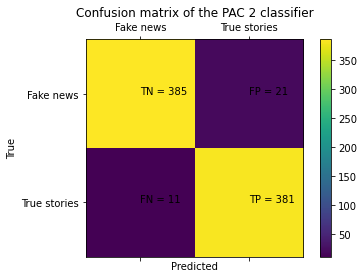

In [37]:
plot_confusion_matrix(y_testW2V, y_pred, 'Fake news', 'True stories', 'PAC 2')

In [38]:
print("                       Classification_report")
print()
print(classification_report(y_pred , y_testW2V))

                       Classification_report

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       396
           1       0.97      0.95      0.96       402

    accuracy                           0.96       798
   macro avg       0.96      0.96      0.96       798
weighted avg       0.96      0.96      0.96       798



#### Word2Vec with Logistic Regression Classifier

In [39]:
LogRmodelW2V = LogisticRegression()
LogRmodelW2V.fit(X_trainW2V_vect_avg, y_trainW2V.values.ravel())
y_pred = LogRmodelW2V.predict(X_testW2V_vect_avg)
score = accuracy_score(y_testW2V, y_pred)
 
print("Accuracy: ",round(score*100,2),"%")


Accuracy:  94.11 %


#### Word2Vec with Linear Subject Machine Classifier

In [40]:
LinSVCmodelW2V = LinearSVC(random_state=0)
LinSVCmodelW2V.fit(X_trainW2V_vect_avg, y_trainW2V.values.ravel())
y_pred = LinSVCmodelW2V.predict(X_testW2V_vect_avg)
score = accuracy_score(y_testW2V, y_pred)
 
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  95.36 %


#### Word2Vec with Multinomial Naive Bayes Classifier

In [41]:
#Tried Multinomial NB and got value error due to negative values in X data
#MulNBmodelW2V = MultinomialNB()
#MulNBmodelW2V.fit(X_trainW2V_vect_avg, y_trainW2V.values.ravel())
#y_pred = MulNBmodelW2V.predict(X_testW2V_vect_avg)
#score = accuracy_score(y_testW2V, y_pred)
 
#print("Accuracy: ",round(score*100,2),"%")

#### Observations and conclusion re Word2Vec
None of models worked that well with W2V, with the accuracy ratings ranging from c90% to 94% (best was the RandomForestClassifier on 94.49%), which is significantly below the TF-IDF vectorization.

Thus, I decided to stick with TF-IDF vectorization and focus on the two most successful models/algorithms with that form of vectorization, namely PassiveAggressive and Linear SVM.


## Model selection

Working the selections, turning the parameters and hyperparameters might improve performance

### Passive Aggressive Classifier (PAC) Model Tuning

The most important parameters for PAC are:

-  C : This is the regularization parameter, and denotes the penalization the model will make on an incorrect prediction. The default is set to 1.0
-  max_iter : The maximum number of iterations the model makes over the training data.
- tol : The stopping criterion. If it is set to None, the model will stop when (loss > previous_loss  –  tol). By default, it is set to 1e-3.


In [42]:
#Second model, varying C parameter
PACmodel2 = PassiveAggressiveClassifier(C = 0.5, max_iter=50, random_state = 5)
PACmodel2.fit(tfidf_train, y_train)
y_pred = PACmodel2.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)
 
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  98.62 %


[[403   6]
 [  5 384]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


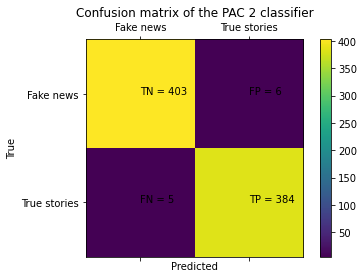

In [43]:
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'PAC 2')

In [44]:
print("                       Classification_report")
print()
print(classification_report(y_pred , y_test))

                       Classification_report

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       408
           1       0.99      0.98      0.99       390

    accuracy                           0.99       798
   macro avg       0.99      0.99      0.99       798
weighted avg       0.99      0.99      0.99       798



In [45]:
# Third model, C at 0.5, but with more iterations
PACmodel3 = PassiveAggressiveClassifier(C = 0.5, max_iter=100, random_state = 5)
PACmodel3.fit(tfidf_train, y_train)
y_pred = PACmodel3.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)
 
print("Accuracy: ",round(score*100,2),"%")


Accuracy:  98.62 %


[[403   6]
 [  5 384]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


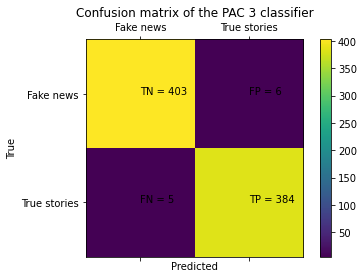

In [46]:
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'PAC 3')

In [47]:
#Fourth model, trying reduced C, and reverting to 50 iterations max
PACmodel4 = PassiveAggressiveClassifier(C = 0.25, max_iter=50, random_state = 5)
PACmodel4.fit(tfidf_train, y_train)
y_pred = PACmodel4.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)
 
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  98.37 %


[[402   7]
 [  6 383]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


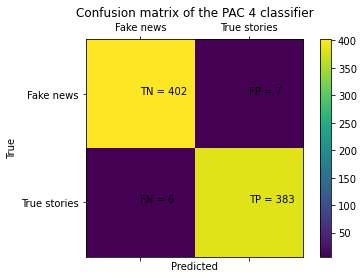

In [48]:
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'PAC 4')

In [49]:
#Fifth model, reduced C, more iterations
PACmodel5 = PassiveAggressiveClassifier(C = 0.25, max_iter=150, random_state = 5)
PACmodel5.fit(tfidf_train, y_train)
y_pred = PACmodel5.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)

print("Accuracy: ",round(score*100,2),"%")

Accuracy:  98.37 %


In [50]:
# Sixth model, very low C, 50 iterations
PACmodel6 = PassiveAggressiveClassifier(C = 0.1, max_iter=50, random_state = 5)
PACmodel6.fit(tfidf_train, y_train)
y_pred = PACmodel6.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)

print("Accuracy: ",round(score*100,2),"%")

Accuracy:  98.5 %


In [51]:
#Seventh model, higher C, 50 iterations
PACmodel7 = PassiveAggressiveClassifier(C = 0.8, max_iter=50, random_state = 5)
PACmodel7.fit(tfidf_train, y_train)
y_pred = PACmodel7.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)

print("Accuracy: ",round(score*100,2),"%")

Accuracy:  98.62 %


In [52]:
print("                       Classification_report")
print()
print(classification_report(y_pred , y_test))

                       Classification_report

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       410
           1       0.98      0.99      0.99       388

    accuracy                           0.99       798
   macro avg       0.99      0.99      0.99       798
weighted avg       0.99      0.99      0.99       798



[[404   5]
 [  6 383]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


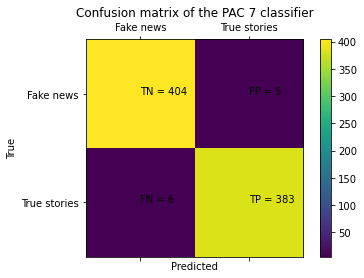

<Figure size 432x288 with 0 Axes>

In [53]:
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'PAC 7')
plt.savefig('Confusion matrix of the PAC 7 Classifier')

In [54]:
#Change tol
PACmodel2A = PassiveAggressiveClassifier(C = 0.5, max_iter=50, tol=1e-4,random_state = 5)
PACmodel2A.fit(tfidf_train, y_train)
y_pred = PACmodel2A.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)
 
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  98.62 %


[[403   6]
 [  5 384]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


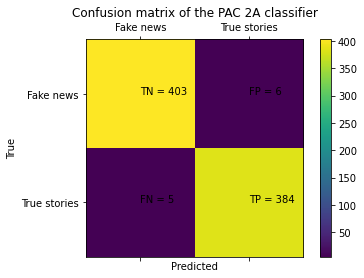

In [55]:
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'PAC 2A')

In [56]:
#Change tol
PACmodel2B = PassiveAggressiveClassifier(C = 0.5, max_iter=50, tol=1e-5,random_state = 5)
PACmodel2B.fit(tfidf_train, y_train)
y_pred = PACmodel2B.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)
 
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  98.62 %


[[403   6]
 [  5 384]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


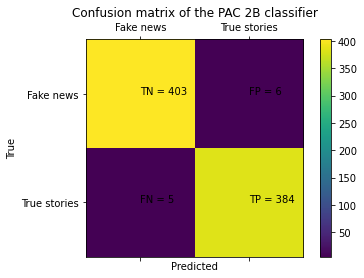

In [57]:
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'PAC 2B')

In [58]:
# Grid search for best parameters for PAC
# define model and parameters
PACmodelTune = PassiveAggressiveClassifier()
C = [1.0, 0.8, 0.6, 0.5, 0.3, 0.1, 0.01]
tol = [0.001, 0.0001, 0.00001]
max_iter = [1000, 500, 100, 50]

# define grid search
grid = dict(C=C, tol=tol, max_iter=max_iter)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=PACmodelTune, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(tfidf_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.985266 using {'C': 0.5, 'max_iter': 100, 'tol': 0.0001}
0.984117 (0.007371) with: {'C': 1.0, 'max_iter': 1000, 'tol': 0.001}
0.984639 (0.007255) with: {'C': 1.0, 'max_iter': 1000, 'tol': 0.0001}
0.984326 (0.006111) with: {'C': 1.0, 'max_iter': 1000, 'tol': 1e-05}
0.984535 (0.006421) with: {'C': 1.0, 'max_iter': 500, 'tol': 0.001}
0.984848 (0.006326) with: {'C': 1.0, 'max_iter': 500, 'tol': 0.0001}
0.984535 (0.007718) with: {'C': 1.0, 'max_iter': 500, 'tol': 1e-05}
0.984013 (0.006022) with: {'C': 1.0, 'max_iter': 100, 'tol': 0.001}
0.983177 (0.006891) with: {'C': 1.0, 'max_iter': 100, 'tol': 0.0001}
0.983699 (0.006596) with: {'C': 1.0, 'max_iter': 100, 'tol': 1e-05}
0.983699 (0.007480) with: {'C': 1.0, 'max_iter': 50, 'tol': 0.001}
0.984431 (0.007032) with: {'C': 1.0, 'max_iter': 50, 'tol': 0.0001}
0.984326 (0.006820) with: {'C': 1.0, 'max_iter': 50, 'tol': 1e-05}
0.984013 (0.006740) with: {'C': 0.8, 'max_iter': 1000, 'tol': 0.001}
0.984117 (0.006912) with: {'C': 0.8, 'max_iter'

In [59]:
PACmodelTuned = PassiveAggressiveClassifier(C=0.3, max_iter=100, tol=0.001, random_state=0)
PACmodelTuned.fit(tfidf_train, y_train)
y_pred = PACmodelTuned.predict(tfidf_test)

score = accuracy_score(y_test, y_pred)
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  98.5 %


[[403   6]
 [  6 383]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


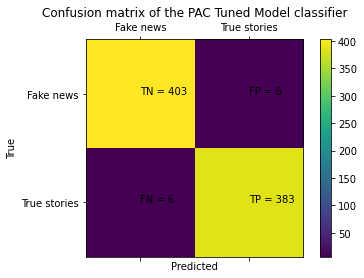

In [60]:
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'PAC Tuned Model')

In [61]:
print("                       Classification_report")
print()
print(classification_report(y_pred , y_test))

                       Classification_report

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       409
           1       0.98      0.98      0.98       389

    accuracy                           0.98       798
   macro avg       0.98      0.98      0.98       798
weighted avg       0.98      0.98      0.98       798



By adjusting the parameters slightly, you can marginally improve the accuracy rating and even reduce the the number of false positives slightly. The most successful model with manual adjustment was PAC Model 7, with just a slight reduction on defauLt C parameter, and which reducd the number of false positives to only 5.

When I carried out a GridSearch, this recommended a slightly different set of optimal parameters (ie, a significantly reduced C, a higher number of max_iterations, etc, but the number of false positives was higher, so I decided to stick with the manually tuned PAC Model 7

### Linear SVM Model Tuning

Linear SVM has a similar set of parameters to PAC, so I followed a similar approach to tuning. The standard, preferred penalty parameter is l2, so I retained this.

In [62]:
LinearSVC.get_params(LinSVMmodel, deep=True)

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 0}

In [63]:
LinSVMmodel2 = LinearSVC(C=0.5, random_state=0)
LinSVMmodel2.fit(tfidf_train, y_train)
y_pred = LinSVMmodel2.predict(tfidf_test)

score = accuracy_score(y_test, y_pred)
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  98.12 %


[[399  10]
 [  5 384]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


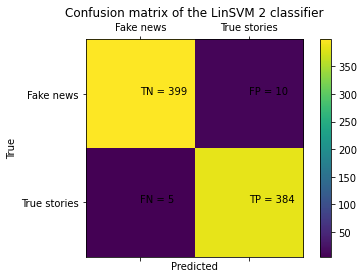

In [64]:
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'LinSVM 2')

In [65]:
LinSVMmodel3 = LinearSVC(C=0.5, penalty='l1', random_state=0, dual=False)
LinSVMmodel3.fit(tfidf_train, y_train)
y_pred = LinSVMmodel3.predict(tfidf_test)

score = accuracy_score(y_test, y_pred)
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  97.37 %


[[401   8]
 [ 13 376]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


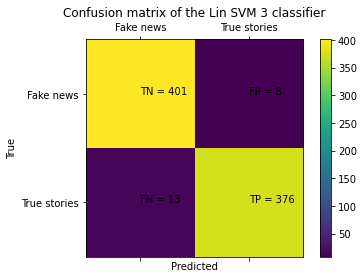

In [66]:
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'Lin SVM 3')

In [67]:
LinSVMmodel4 = LinearSVC(C=0.5, max_iter=100, random_state=0)
LinSVMmodel4.fit(tfidf_train, y_train)
y_pred = LinSVMmodel4.predict(tfidf_test)

score = accuracy_score(y_test, y_pred)
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  98.12 %


[[399  10]
 [  5 384]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


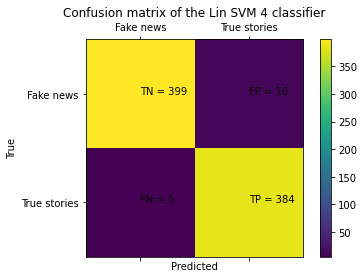

In [68]:
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'Lin SVM 4')

In [69]:
LinSVMmodel5 = LinearSVC(C=1.0, max_iter=100, random_state=0)
LinSVMmodel5.fit(tfidf_train, y_train)
y_pred = LinSVMmodel5.predict(tfidf_test)

score = accuracy_score(y_test, y_pred)
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  98.5 %


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


[[401   8]
 [  4 385]]


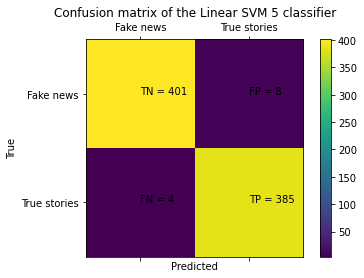

In [70]:
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'Linear SVM 5')

In [71]:
# Grid search
# define model and parameters
LinSVMmodelTune = LinearSVC()
C = [1.0, 0.8, 0.6, 0.5, 0.3, 0.1, 0.01]
tol = [0.001, 0.0001, 0.00001]
max_iter = [1000, 500, 100, 50]

# define grid search
grid = dict(C=C, tol=tol, max_iter=max_iter)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=LinSVMmodelTune, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(tfidf_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.985371 using {'C': 0.8, 'max_iter': 50, 'tol': 0.001}
0.985266 (0.007155) with: {'C': 1.0, 'max_iter': 1000, 'tol': 0.001}
0.985266 (0.007155) with: {'C': 1.0, 'max_iter': 1000, 'tol': 0.0001}
0.985266 (0.007155) with: {'C': 1.0, 'max_iter': 1000, 'tol': 1e-05}
0.985266 (0.007155) with: {'C': 1.0, 'max_iter': 500, 'tol': 0.001}
0.985266 (0.007155) with: {'C': 1.0, 'max_iter': 500, 'tol': 0.0001}
0.985266 (0.007155) with: {'C': 1.0, 'max_iter': 500, 'tol': 1e-05}
0.985266 (0.007155) with: {'C': 1.0, 'max_iter': 100, 'tol': 0.001}
0.985266 (0.007155) with: {'C': 1.0, 'max_iter': 100, 'tol': 0.0001}
0.985266 (0.007155) with: {'C': 1.0, 'max_iter': 100, 'tol': 1e-05}
0.985266 (0.007155) with: {'C': 1.0, 'max_iter': 50, 'tol': 0.001}
0.985266 (0.007155) with: {'C': 1.0, 'max_iter': 50, 'tol': 0.0001}
0.985266 (0.007155) with: {'C': 1.0, 'max_iter': 50, 'tol': 1e-05}
0.985266 (0.007109) with: {'C': 0.8, 'max_iter': 1000, 'tol': 0.001}
0.985266 (0.007109) with: {'C': 0.8, 'max_iter': 

The first Linear SVM was the best.

In [72]:
LinSVMmodelTuned = LinearSVC(C=0.8, max_iter=1000, tol=0.001, random_state=0)
LinSVMmodelTuned.fit(tfidf_train, y_train)
y_pred = LinSVMmodelTuned.predict(tfidf_test)

score = accuracy_score(y_test, y_pred)
print("Accuracy: ",round(score*100,2),"%")

Accuracy:  98.5 %


[[401   8]
 [  4 385]]


C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\Pearc\AppData\Local\Temp\ipykernel_51192\2170059444.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


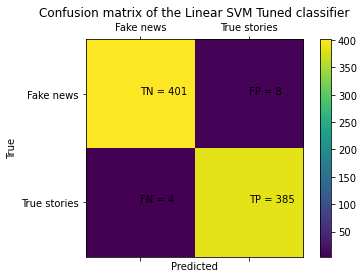

In [73]:
plot_confusion_matrix(y_test, y_pred, 'Fake news', 'True stories', 'Linear SVM Tuned')

In [74]:
print("                       Classification_report")
print()
print(classification_report(y_pred , y_test))

                       Classification_report

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       405
           1       0.99      0.98      0.98       393

    accuracy                           0.98       798
   macro avg       0.99      0.98      0.98       798
weighted avg       0.99      0.98      0.98       798



As with PAC, tuning the parameters made marginal improvements to accuracy, but unfortunately I could reduce the number of false positives. Thus, the first Linear SVM model (manually tuned) was the best, something that was confirmed by a GridSearch.

Overally, however, even the best Linear SVM model was slightly worse that some of the PAC models and so ultimately, the PassiveAggressive Classifier produced the best model - in particular Model 7.

## Conclusion

Having tried a number of classifiers, it's clear that once you have a cleaned, standardised and vectorized dataset of articles/text, it's possible to build a passable model with many of them. However, in order to refine that model and focus on things that really matter - including in the context of fake news, reducing the number fake articles that slip through the net - then only the PassiveAggressive Classifier and the Linear Subject Vector Machine Classifier were really up to the job. Parameter tuning offered only marginal improvements, but was worth doing for the PassiveAggressive Classifier.

In terms of word vectorization, it was interesting to see that TF-IFD performed well, in marked contrast to Word2Vec. This may be due to the size of the dataset. Even though the dataset was of a decent size (4000 articles), it may be that Word2Vec works better on much larger datasets.